In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import boxcox
from pandas.plotting import lag_plot

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, scale
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_val_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import statsmodels.graphics.tsaplots as tsa_plots
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings

In [2]:
df = pd.read_excel("Airlines+Data.xlsx")
df.head()

,Month,Passengers
0,1995-01-01,112
1,1995-02-01,118
2,1995-03-01,132
3,1995-04-01,129
4,1995-05-01,121


## Data Exploration

In [3]:
df.shape

(96, 2)

In [4]:
df.isnull().any()

Month         False
Passengers    False
dtype: bool

In [5]:
df.isnull().sum()

Month         0
Passengers    0
dtype: int64

<Axes: >

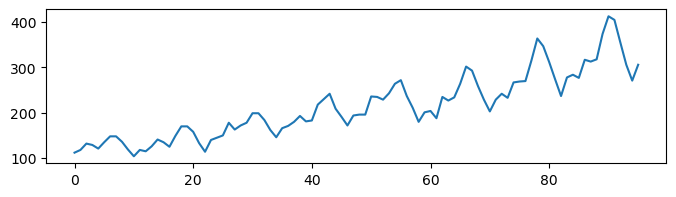

In [6]:
df.Passengers.plot(figsize=(8,2))

In [7]:
df.dtypes

Month         datetime64[ns]
Passengers             int64
dtype: object

In [8]:
df.nunique()

Month         96
Passengers    80
dtype: int64

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month       96 non-null     datetime64[ns]
 1   Passengers  96 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.6 KB


In [10]:
df[df.duplicated()].shape

(0, 2)

In [11]:
df.describe()

,Passengers
count,96.000000
mean,213.708333
std,71.918216
min,104.000000
25%,156.000000
50%,200.000000
75%,264.750000
max,413.000000


In [12]:
df.rename({'Month':'Date'},axis=1, inplace=True)

In [13]:
df1 = df.copy()
df1.set_index('Date',inplace=True)
df1.index.year

Int64Index([1995, 1995, 1995, 1995, 1995, 1995, 1995, 1995, 1995, 1995, 1995,
            1995, 1996, 1996, 1996, 1996, 1996, 1996, 1996, 1996, 1996, 1996,
            1996, 1996, 1997, 1997, 1997, 1997, 1997, 1997, 1997, 1997, 1997,
            1997, 1997, 1997, 1998, 1998, 1998, 1998, 1998, 1998, 1998, 1998,
            1998, 1998, 1998, 1998, 1999, 1999, 1999, 1999, 1999, 1999, 1999,
            1999, 1999, 1999, 1999, 1999, 2000, 2000, 2000, 2000, 2000, 2000,
            2000, 2000, 2000, 2000, 2000, 2000, 2001, 2001, 2001, 2001, 2001,
            2001, 2001, 2001, 2001, 2001, 2001, 2001, 2002, 2002, 2002, 2002,
            2002, 2002, 2002, 2002, 2002, 2002, 2002, 2002],
           dtype='int64', name='Date')

In [14]:
df1.head()

,Passengers
Date,
1995-01-01,112
1995-02-01,118
1995-03-01,132
1995-04-01,129
1995-05-01,121


In [15]:
df["Date"] = pd.to_datetime(df.Date,format="%b-%y")
df["month"] = df.Date.dt.strftime("%b") # month extraction
df["year"] = df.Date.dt.strftime("%Y") # year extraction
df.head()

,Date,Passengers,month,year
0,1995-01-01,112,Jan,1995
1,1995-02-01,118,Feb,1995
2,1995-03-01,132,Mar,1995
3,1995-04-01,129,Apr,1995
4,1995-05-01,121,May,1995


<Axes: xlabel='month', ylabel='year'>

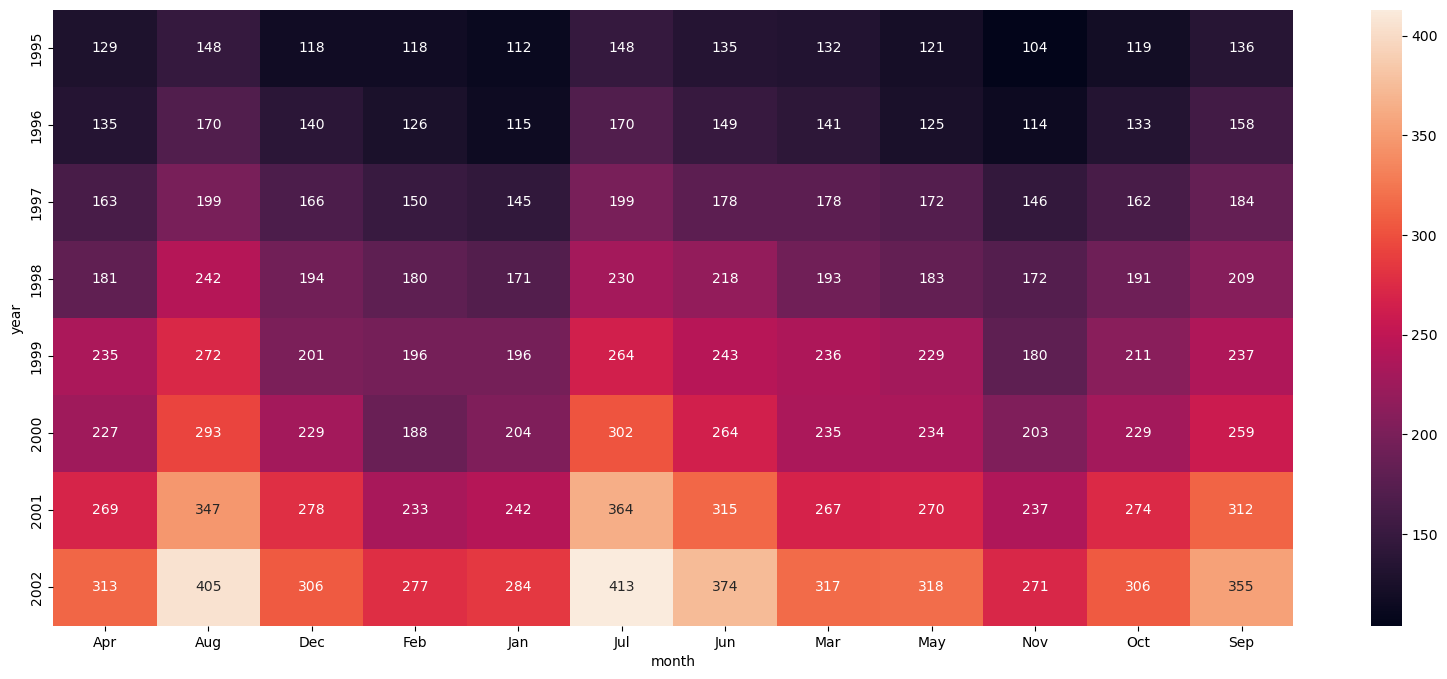

In [16]:
plt.figure(figsize=(20,8))
heatmap_y_month = pd.pivot_table(data=df,values="Passengers",index="year",columns="month",aggfunc="mean",fill_value=0)
sns.heatmap(heatmap_y_month,annot=True,fmt="g")

Heatmap of number of passengers travelling in each month over the years 1995-2002.

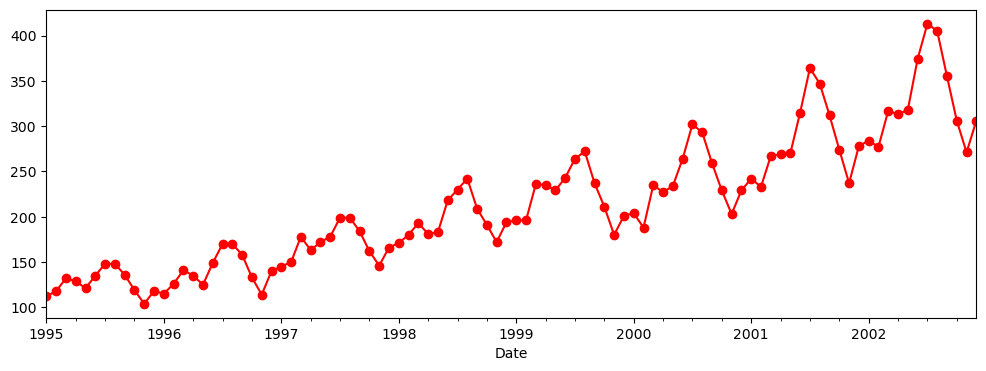

In [17]:
df1['Passengers'].plot(figsize=(12, 4),color='red',marker='o')
plt.show()

Due to uptrend and an increase in variance across years, we can say that the data is not stationary

<Axes: xlabel='year', ylabel='Passengers'>

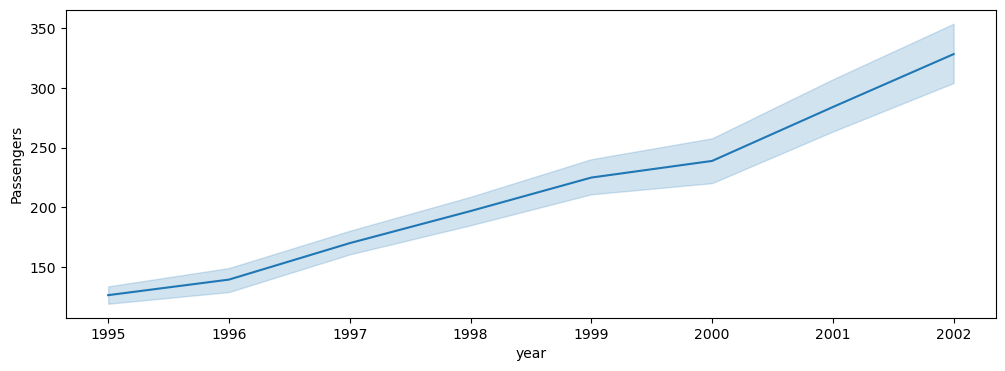

In [18]:
plt.figure(figsize=(12,4))
sns.lineplot(x="year",y="Passengers",data=df)

We can see the uptrend from the lineplot.

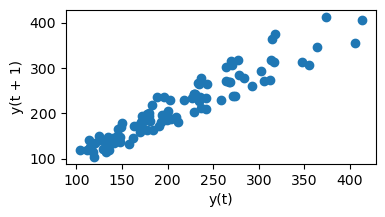

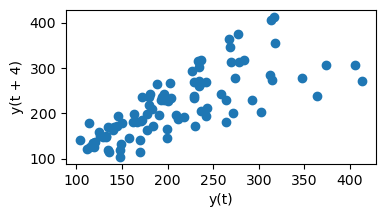

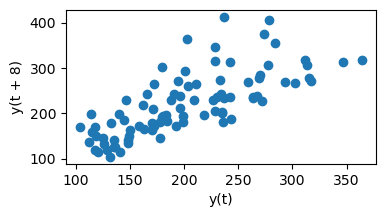

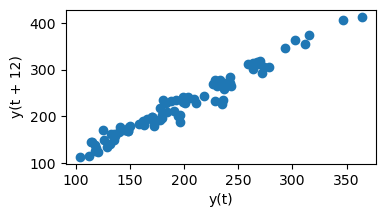

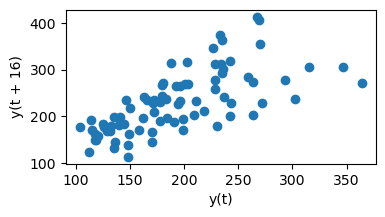

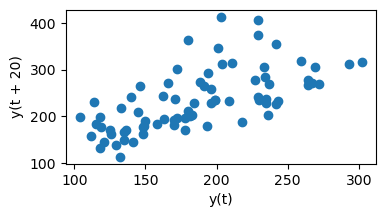

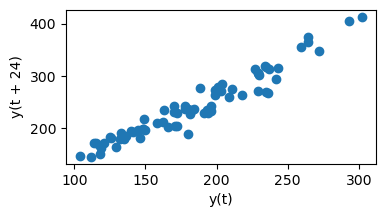

In [19]:
for i in [1, 4, 8, 12, 16, 20, 24]:
    plt.figure(figsize=(4,2))
    lag_plot(df.Passengers, lag=i)
    plt.show()

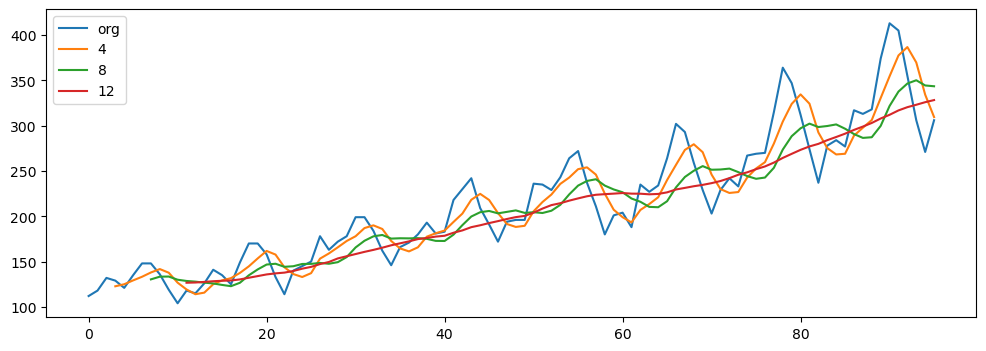

In [20]:
plt.figure(figsize=(12,4))
df.Passengers.plot(label="org")
for i in range(4,13,4):
    df["Passengers"].rolling(i).mean().plot(label=str(i))
plt.legend(loc='best')

The moving average plot shows the trend very well.

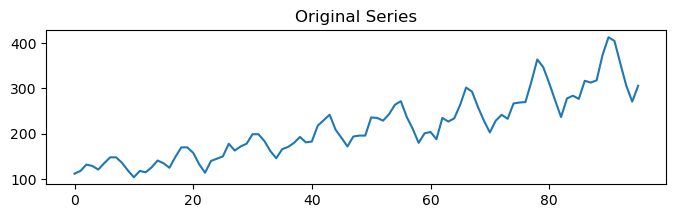

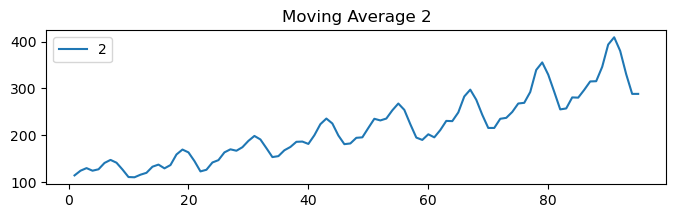

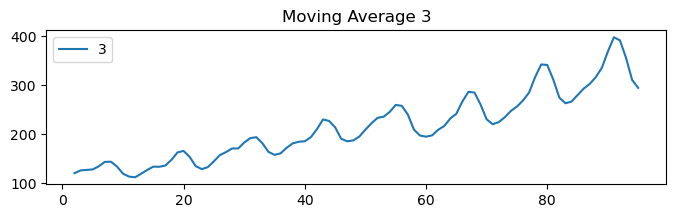

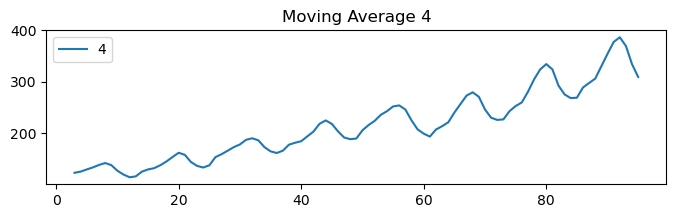

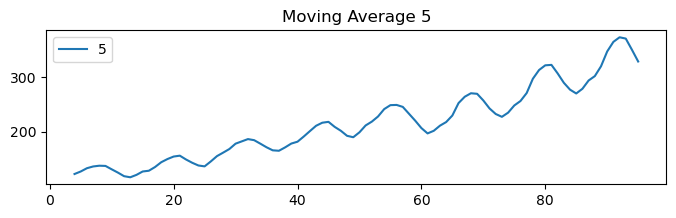

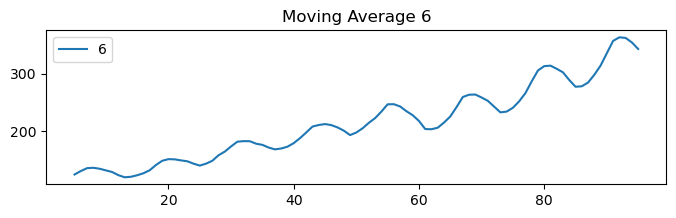

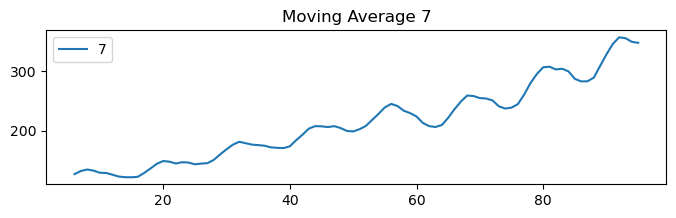

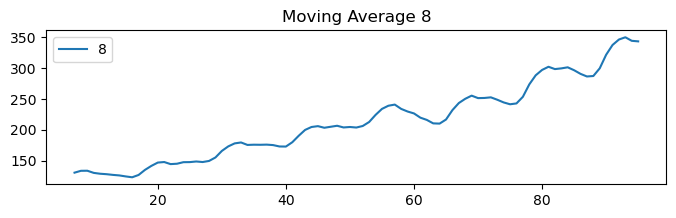

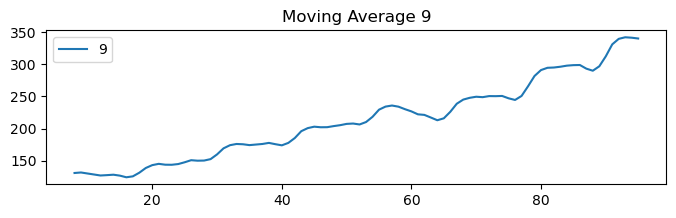

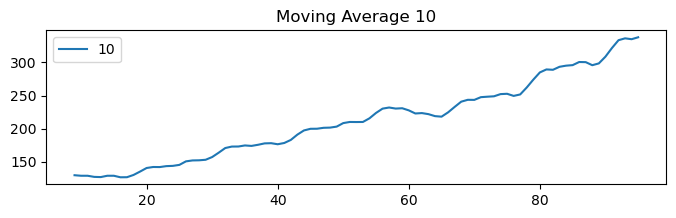

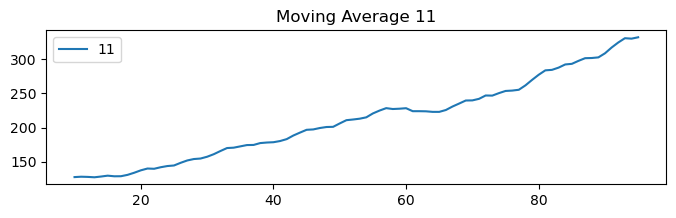

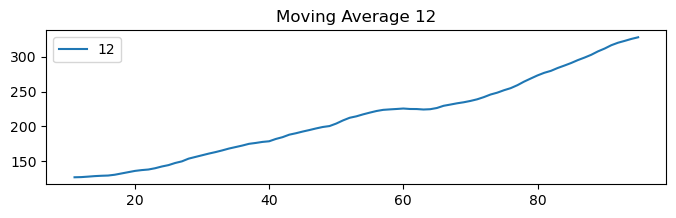

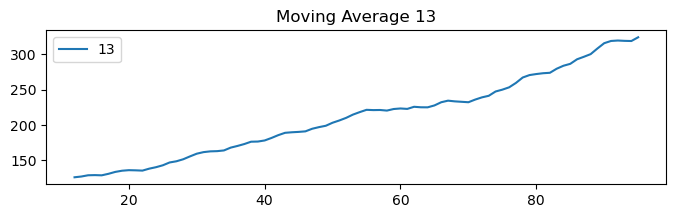

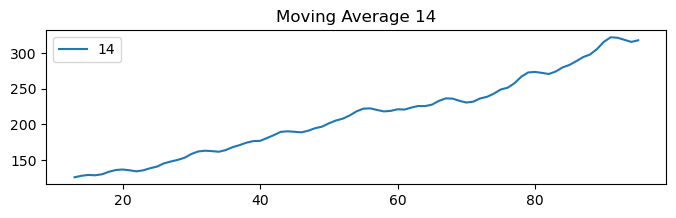

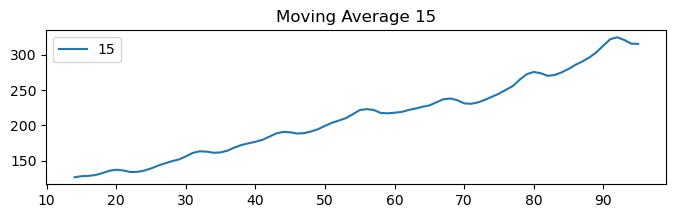

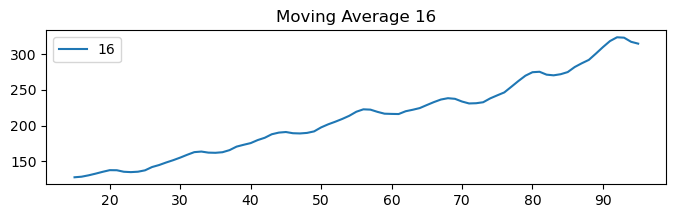

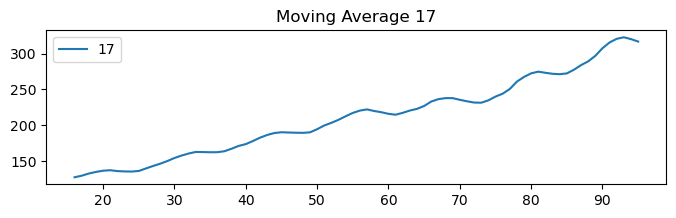

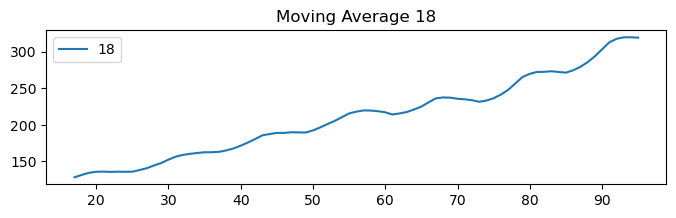

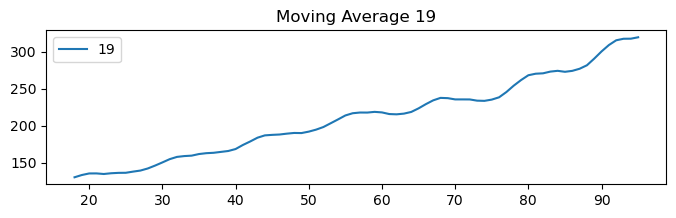

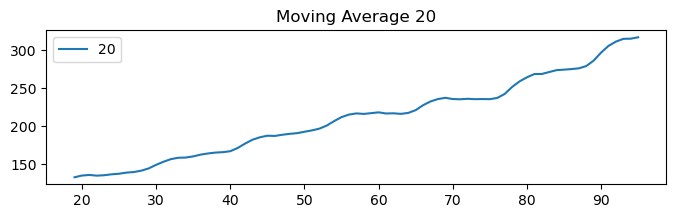

In [21]:
plt.figure(figsize=(8,2))
df.Passengers.plot(label="org")
plt.title("Original Series")
for i in range(2,21):
    plt.figure(figsize=(8,2))
    df["Passengers"].rolling(i).mean().plot(label=str(i))
    plt.title("Moving Average "+str(i))
    plt.legend(loc='best')
    plt.show()

The moving average 12 shows the smoothest plot as can be seen from the plots made.

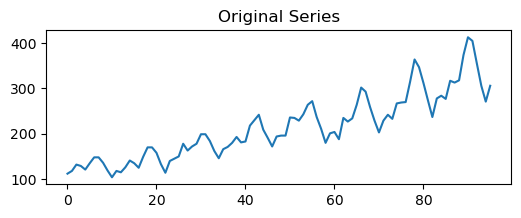

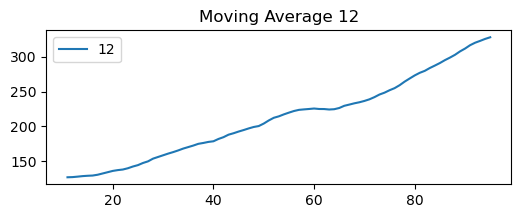

In [22]:
plt.figure(figsize=(6,2))
df.Passengers.plot(label="org")
plt.title("Original Series")
plt.figure(figsize=(6,2))
df["Passengers"].rolling(12).mean().plot(label=str(12))
plt.title("Moving Average "+str(12))
plt.legend(loc='best')
plt.show()

The original dataset and moving average with 12 datapoints averaged are shown side by side to understand the difference.

#### Time series decomposition plot

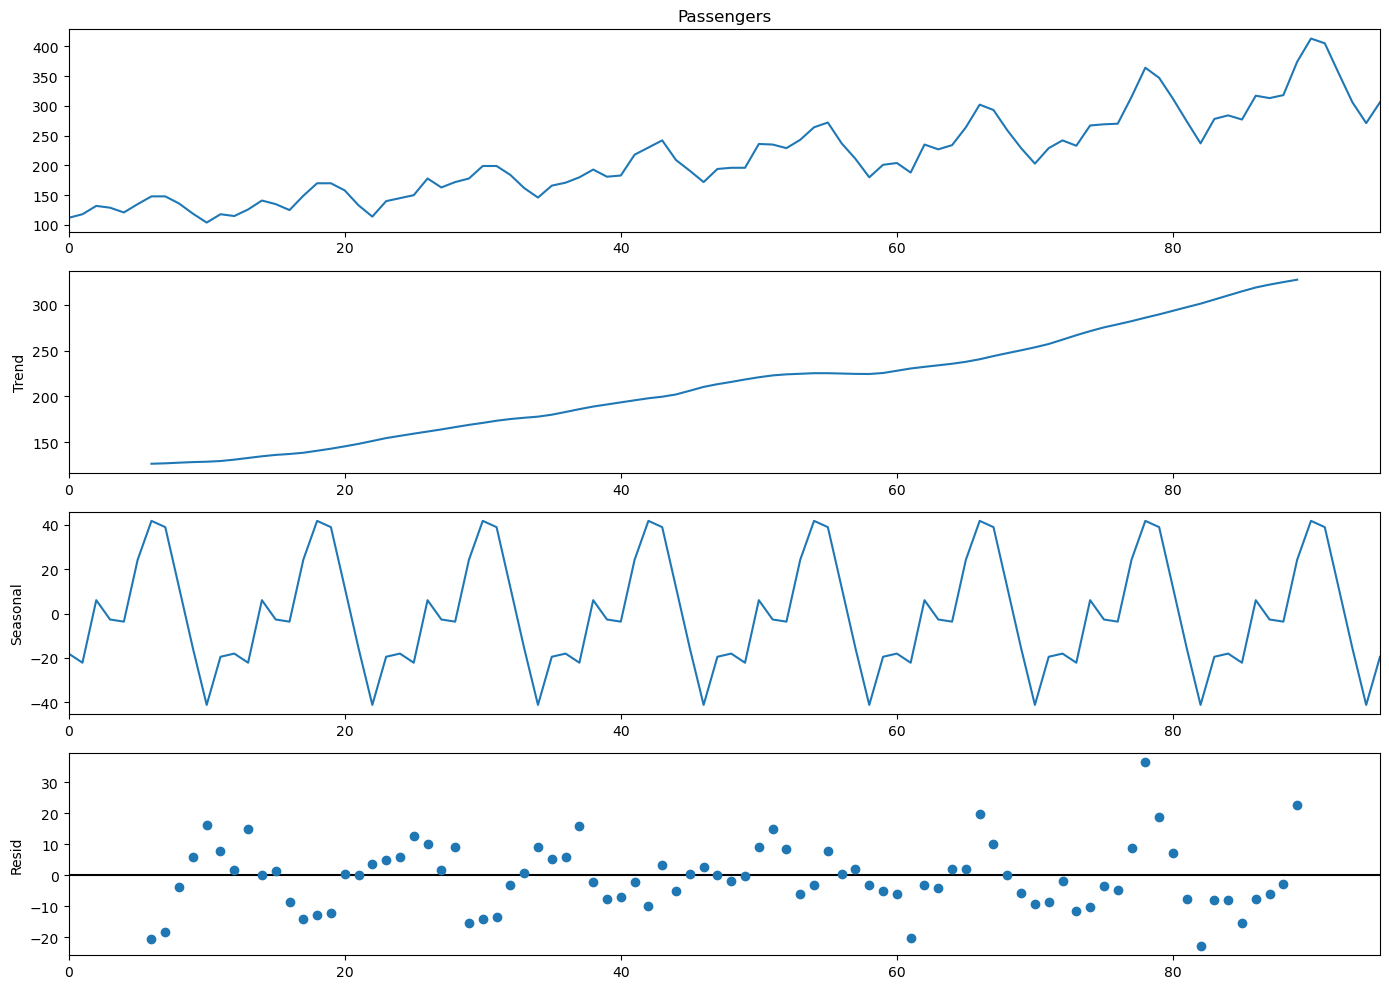

In [23]:
decompose_ts_add = seasonal_decompose(df.Passengers,period=12)
with plt.rc_context():
    plt.rc("figure", figsize=(14,10))
    decompose_ts_add.plot()
    plt.show()

#### ACF and PACF plots

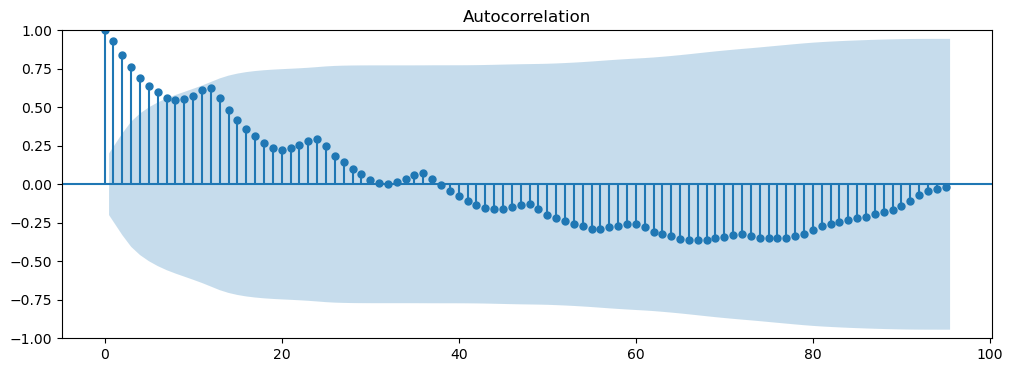

In [24]:
with plt.rc_context():
    plt.rc("figure", figsize=(12,4))
    tsa_plots.plot_acf(df.Passengers,lags=95)
    plt.show()

After lag_7, the correlation is inside the shaded region and is favourable.

/Users/hari/anaconda3/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


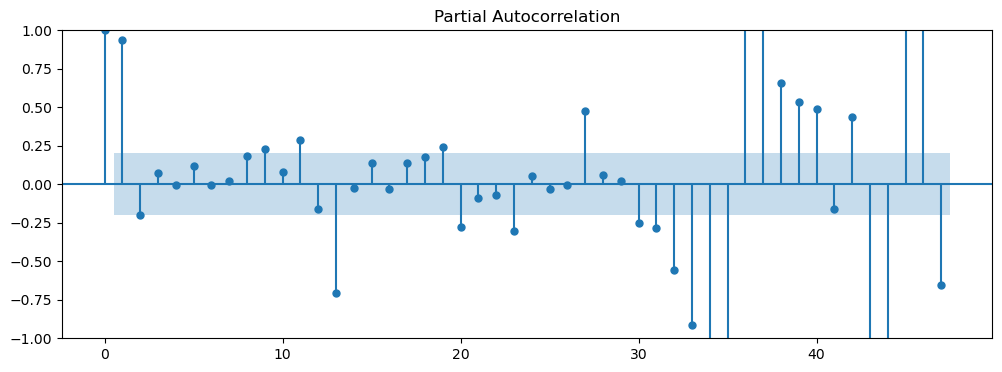

In [25]:
with plt.rc_context():
    plt.rc("figure", figsize=(12,4))
    tsa_plots.plot_pacf(df.Passengers,lags=47)
    plt.show()

### Time series decomposition

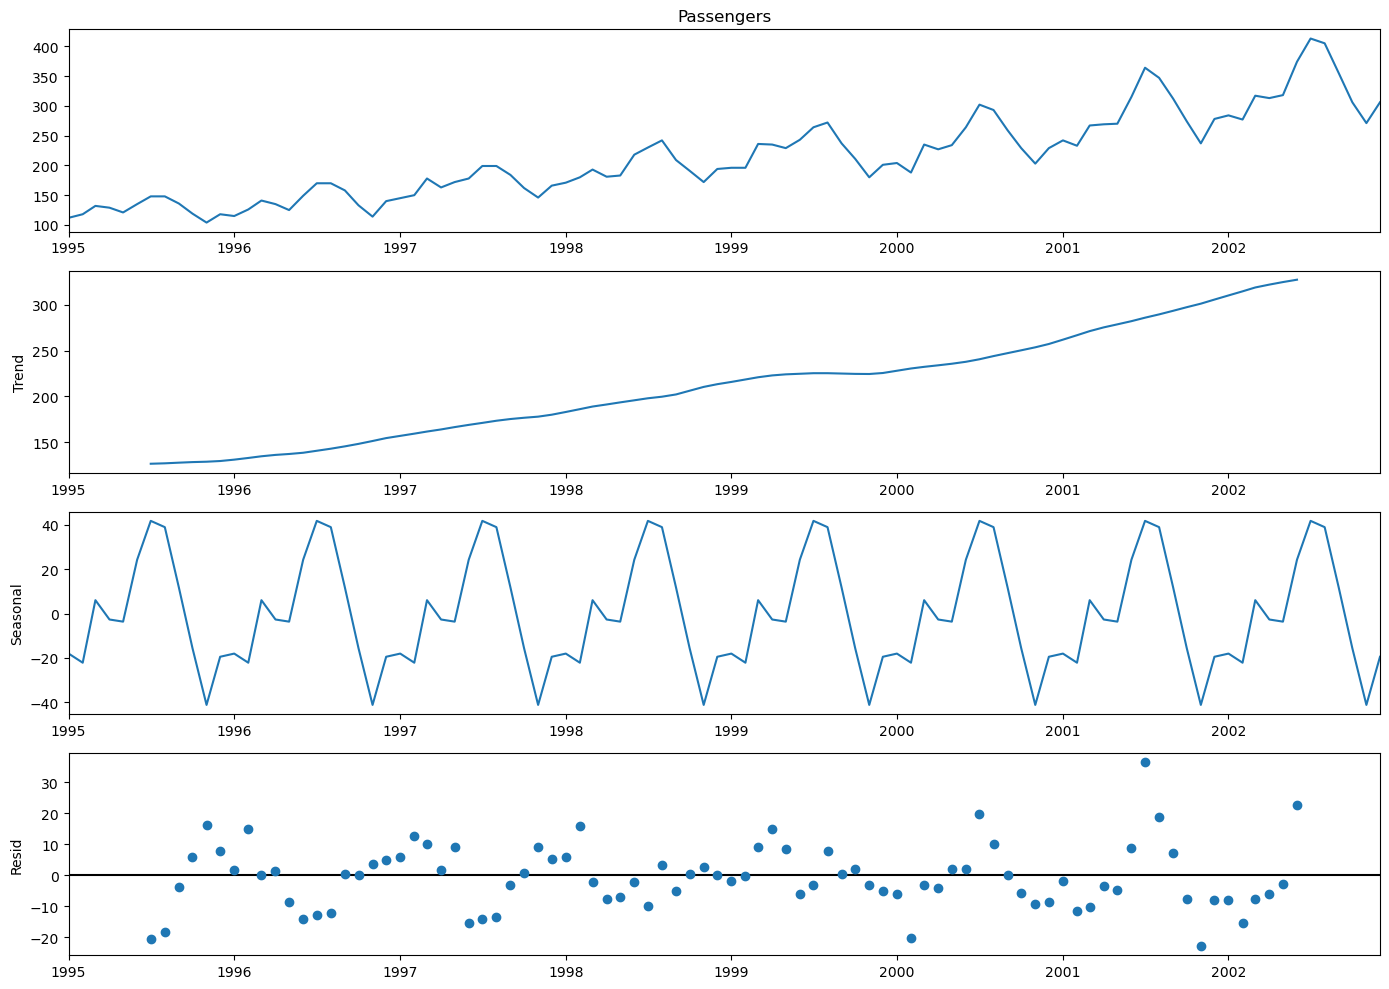

In [28]:
decompose_ts_add = seasonal_decompose(df1.Passengers,period=12, model='additive')
with plt.rc_context():
    plt.rc("figure", figsize=(14,10))
    decompose_ts_add.plot()
    plt.show()

The original series is separated into trend, seasonality and noise such that addition of all these components will give the original series.

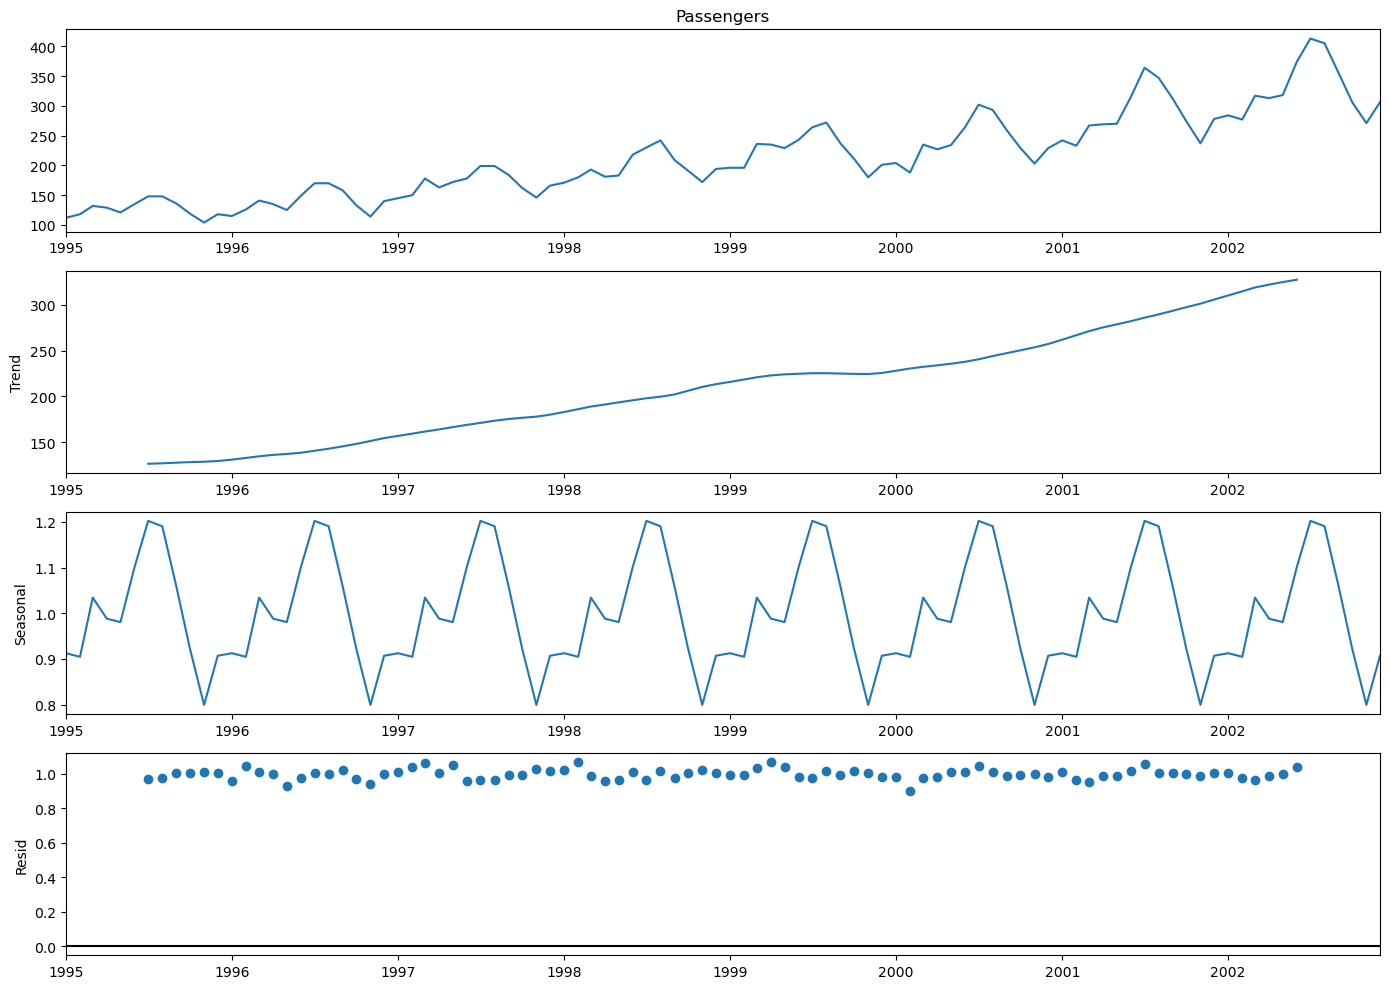

In [29]:
decompose_ts_add = seasonal_decompose(df1.Passengers,period=12, model='multiplicative')
with plt.rc_context():
    plt.rc("figure", figsize=(14,10))
    decompose_ts_add.plot()
    plt.show()

The original series is separated into trend, seasonality and noise such that multiplication of all these components will give the original series.

In [30]:
size = 72
train_data = df1[:size]
test_data = df1[size:]

In [31]:
print('Train:',train_data.index.min(),train_data.index.max(),'\n',
'Test:',test_data.index.min(),test_data.index.max())

Train: 1995-01-01 00:00:00 2000-12-01 00:00:00 
 Test: 2001-01-01 00:00:00 2002-12-01 00:00:00


<Axes: title={'center': 'Test'}, xlabel='Date'>

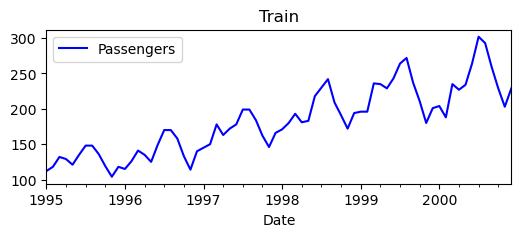

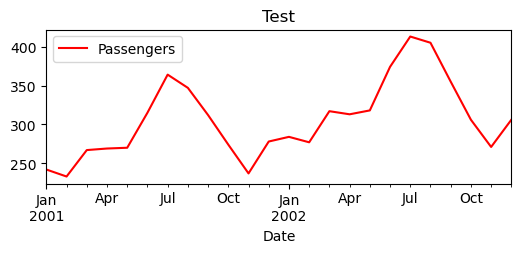

In [32]:
train_data.plot(title = "Train", figsize=(6,2),color='blue')
test_data.plot(title = "Test", figsize=(6,2),color='red')

#### Testing different methods and finding the RMSE with respect to each method

In [33]:
def MAPE(pred,org):
    temp = np.abs((pred-org)/org)*100
    return np.mean(temp)

In [34]:
warnings.filterwarnings("ignore")

# Simple Exponential method
ses_model = SimpleExpSmoothing(train_data['Passengers']).fit(optimized=True)
test_pred_ses = ses_model.forecast(24)
train_pred_ses = ses_model.fittedvalues
test_rmse_ses = np.sqrt(mean_squared_error(test_pred_ses,test_data.Passengers))
train_rmse_ses = np.sqrt(mean_squared_error(train_pred_ses,train_data))
mape_ses = MAPE(test_pred_ses,test_data.Passengers)

# Holt method / Double exponential
dexp_model  = Holt(train_data).fit(optimized=True)
test_pred_dexp = dexp_model.forecast(24)
train_pred_dexp = dexp_model.fittedvalues
test_rmse_dexp = np.sqrt(mean_squared_error(test_pred_dexp,test_data.Passengers))
train_rmse_dexp = np.sqrt(mean_squared_error(train_pred_dexp,train_data))
mape_dexp = MAPE(test_pred_dexp,test_data.Passengers)

# Holts winter exponential smoothing with additive seasonality and trend (Triple Exponential)
texp_add_model  = ExponentialSmoothing(train_data,seasonal="add",trend="add",seasonal_periods=12).fit(optimized=True)
test_pred_ad_texp = texp_add_model.forecast(24)
train_pred_ad_texp = texp_add_model.fittedvalues
test_rmse_ad_texp = np.sqrt(mean_squared_error(test_pred_ad_texp,test_data.Passengers))
train_rmse_ad_texp = np.sqrt(mean_squared_error(train_pred_ad_texp,train_data))
mape_ad_texp = MAPE(test_pred_ad_texp,test_data.Passengers)

# Holts winter exponential smoothing with multiplicative seasonality and additive trend (Triple Exponential)
texp_mul_ad_model  = ExponentialSmoothing(train_data,seasonal="mul",trend="add",seasonal_periods=12).fit(optimized=True)
test_pred_mul_ad_texp = texp_mul_ad_model.forecast(24)
train_pred_mul_ad_texp = texp_mul_ad_model.fittedvalues
test_rmse_mul_ad_texp = np.sqrt(mean_squared_error(test_pred_mul_ad_texp,test_data.Passengers))
train_rmse_mul_ad_texp = np.sqrt(mean_squared_error(train_pred_mul_ad_texp,train_data))
mape_mul_ad_texp = MAPE(test_pred_mul_ad_texp,test_data.Passengers)

# Holts winter exponential smoothing with Additive seasonality and multiplicative trend (Triple Exponential)
texp_ad_mul_model  = ExponentialSmoothing(train_data,seasonal="add",trend="mul",seasonal_periods=12).fit(smoothing_level=0.1, smoothing_slope=0.5)
test_pred_ad_mul_texp  = texp_ad_mul_model.forecast(24)
train_pred_ad_mul_texp  = texp_ad_mul_model.fittedvalues
test_rmse_ad_mul_texp  = np.sqrt(mean_squared_error(test_pred_ad_mul_texp ,test_data.Passengers))
train_rmse_ad_mul_texp  = np.sqrt(mean_squared_error(train_pred_ad_mul_texp ,train_data))
mape_ad_mul_texp  = MAPE(test_pred_ad_mul_texp,test_data.Passengers)

# Holts winter exponential smoothing with multiplicative seasonality and multiplicative trend (Triple Exponential)
texp_mul_model  = ExponentialSmoothing(train_data,seasonal="mul",trend="mul",seasonal_periods=12).fit(optimized=True)
test_pred_mul_texp  = texp_mul_model.forecast(24)
train_pred_mul_texp  = texp_mul_model.fittedvalues
test_rmse_mul_texp  = np.sqrt(mean_squared_error(test_pred_mul_texp ,test_data.Passengers))
train_rmse_mul_texp  = np.sqrt(mean_squared_error(train_pred_mul_texp ,train_data))
mape_mul_texp  = MAPE(test_pred_mul_texp,test_data.Passengers)

In [35]:
Evaluation = {"Models":pd.Series(["Simple_Exp","Double_Exp","Triple_Exp_ad","Triple_Exp_mul_ad","Triple_Exp_ad_mul"\
                                  ,"Triple_Exp_mul"]),\
        "Train_RMSE":pd.Series([train_rmse_ses,train_rmse_dexp,train_rmse_ad_texp,train_rmse_mul_ad_texp,train_rmse_ad_mul_texp,train_rmse_mul_texp]),\
        "Test_MAPE(%)":pd.Series([mape_ses,mape_dexp,mape_ad_texp,mape_mul_ad_texp,mape_ad_mul_texp,mape_mul_texp]),\
        "Test_RMSE_Values":pd.Series([test_rmse_ses,test_rmse_dexp,test_rmse_ad_texp,test_rmse_mul_ad_texp,test_rmse_ad_mul_texp,test_rmse_mul_texp])}
table_evaluation=pd.DataFrame(Evaluation)
table_evaluation.sort_values(['Test_MAPE(%)'], inplace=True, ignore_index=True)
table_evaluation

,Models,Train_RMSE,Test_MAPE(%),Test_RMSE_Values
0,Triple_Exp_mul,6.396750,6.035079,23.058842
1,Triple_Exp_mul_ad,6.386634,9.368409,34.989554
2,Triple_Exp_ad,7.751304,12.084814,47.570269
3,Triple_Exp_ad_mul,12.755540,13.341867,48.342084
4,Double_Exp,18.961292,17.122209,71.552552
5,Simple_Exp,19.031772,23.382283,91.113254


The RMSE and MAPE values obtained for different models are compared here. Holts winter exponential smoothing with multiplicative seasonality and multiplicative trend (Triple Exponential) gives the least RMSE and MAPE.

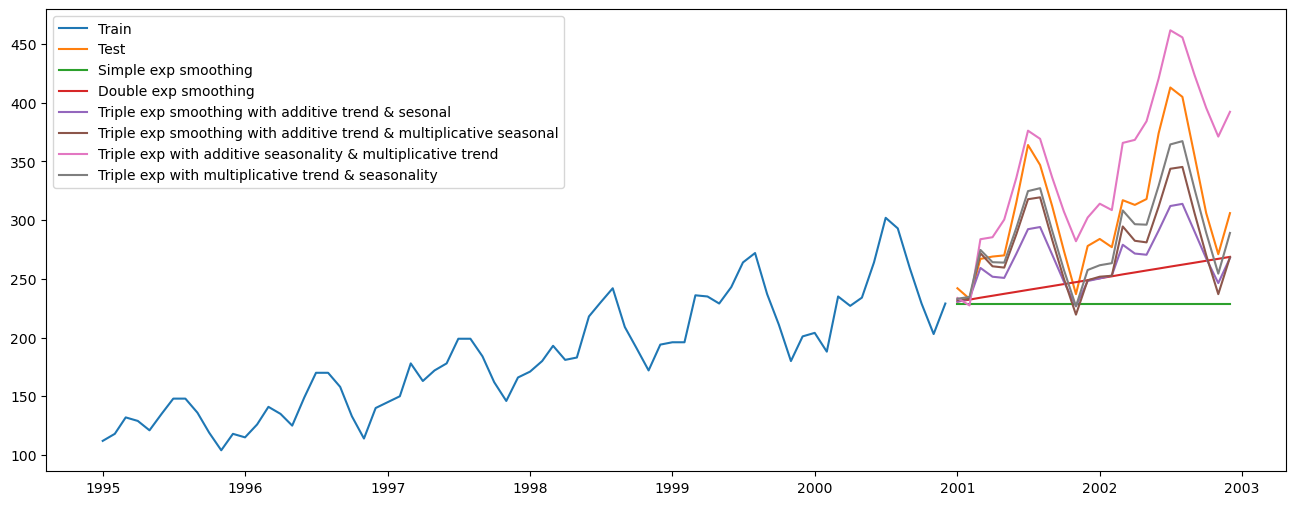

In [36]:
plt.figure(figsize=(16,6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(test_pred_ses, label='Simple exp smoothing')
plt.plot(test_pred_dexp, label='Double exp smoothing')
plt.plot(test_pred_ad_texp, label='Triple exp smoothing with additive trend & sesonal')
plt.plot(test_pred_mul_ad_texp, label='Triple exp smoothing with additive trend & multiplicative seasonal')
plt.plot(test_pred_ad_mul_texp, label='Triple exp with additive seasonality & multiplicative trend')
plt.plot(test_pred_mul_texp, label='Triple exp with multiplicative trend & seasonality')
plt.legend(loc='best')
plt.show()

The plots obtained after prediction after applying the methods are shown here. As can be seen in the dataframe above, the triple exponential smoothing with multiplicative trend and multiplicative seasonality gives the best fit.

## ARIMA

Test of stationarity

In [37]:
def test_stationarity(timeseries):
    
    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()
    
    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries['Passengers'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    print(dfoutput)

In [38]:
sales= pd.DataFrame()
sales['Passengers'] = df1[['Passengers']]
test_stationarity(sales)

Results of Dickey Fuller Test:
Test Statistic                  1.340248
p-value                         0.996825
#Lags Used                     12.000000
Number of Observations Used    83.000000
dtype: float64


Since p-value is 0.9968 > 0.05, this means we have to accept null hypothesis. So, data is non stationary

##### Square root transformation

In [39]:
square_root= pd.DataFrame()
square_root = df1[['Passengers']]
square_root['Passengers'] = np.sqrt(square_root.Passengers)

In [40]:
test_stationarity(square_root)

Results of Dickey Fuller Test:
Test Statistic                  0.451435
p-value                         0.983320
#Lags Used                     12.000000
Number of Observations Used    83.000000
dtype: float64


Null hypothesis rejected. => Non-stationary

##### Log transform

In [41]:
log = pd.DataFrame()
log = df1[['Passengers']]
log['Passengers'] = np.log(log.Passengers)

In [42]:
test_stationarity(log)

Results of Dickey Fuller Test:
Test Statistic                 -0.723027
p-value                         0.840695
#Lags Used                     12.000000
Number of Observations Used    83.000000
dtype: float64


Null hypothesis rejected. => Non-stationary

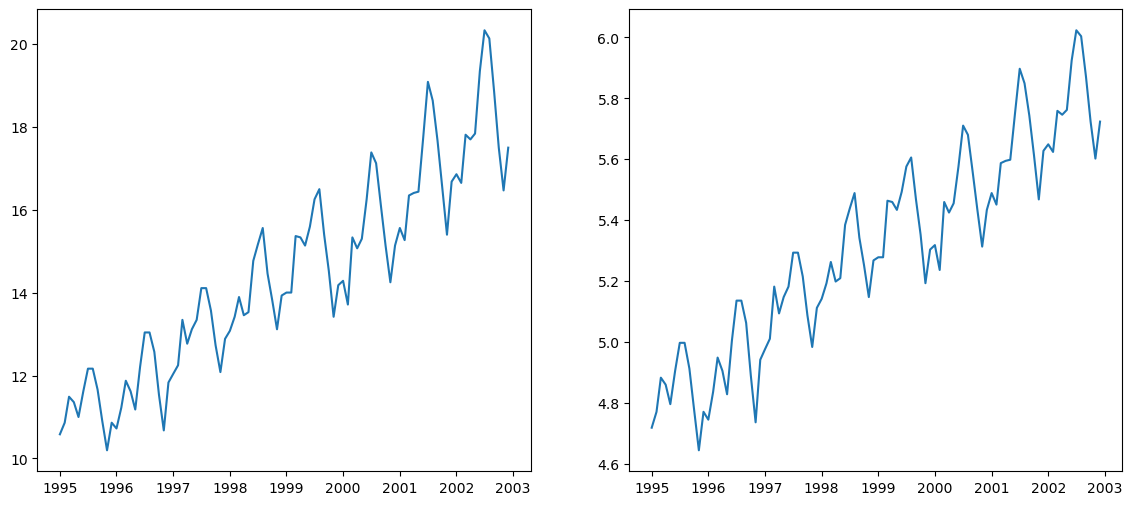

In [43]:
fig=plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.plot(square_root['Passengers'], label='square root transformation')

plt.subplot(1,2,2)
plt.plot(log['Passengers'], label='log transformation')

plt.show()

#### Conversion of non-stationary to stationary dataset

In [44]:
differencing = df1 - df1.shift(1)
differencing.dropna(inplace=True)

In [45]:
test_stationarity(differencing)

Results of Dickey Fuller Test:
Test Statistic                 -2.150002
p-value                         0.224889
#Lags Used                     12.000000
Number of Observations Used    82.000000
dtype: float64


Null hypothesis rejected. => Non-stationary

In [46]:
seasonal_differencing = df1 - df1.shift(12)
seasonal_differencing.dropna(inplace=True)

In [47]:
test_stationarity(seasonal_differencing)

Results of Dickey Fuller Test:
Test Statistic                 -2.690004
p-value                         0.075784
#Lags Used                      1.000000
Number of Observations Used    82.000000
dtype: float64


Null hypothesis rejected. => Non-stationary

##### Transformations

In [48]:
log_diff = log - log.shift(1)
log_diff.dropna(inplace=True)

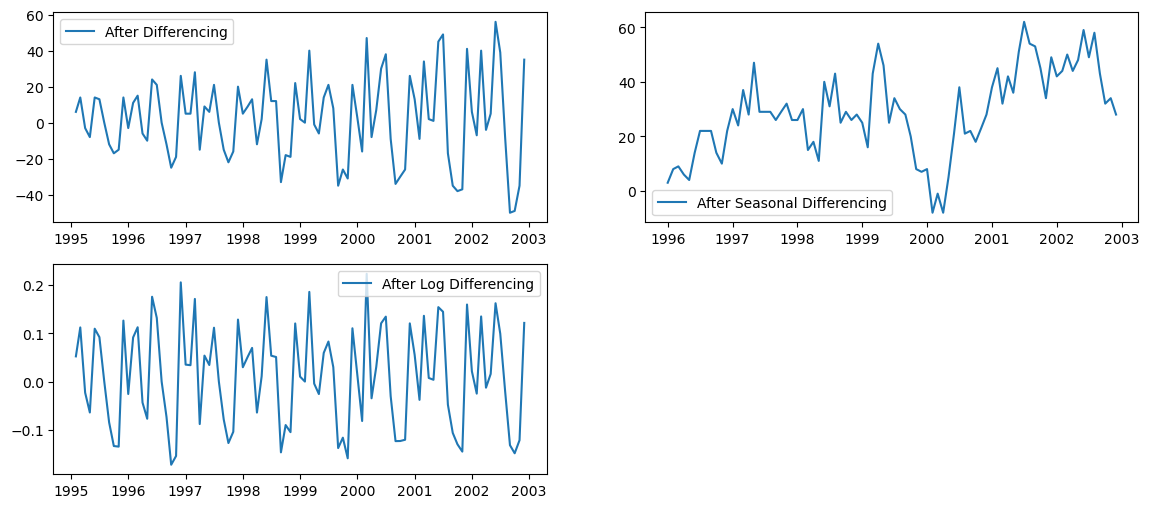

In [49]:
# All plots

fig=plt.figure(figsize=(14,6))
plt.subplot(2,2,1)
plt.plot(differencing, label='After Differencing')
plt.legend(loc='best')

plt.subplot(2,2,2)
plt.plot(seasonal_differencing, label='After Seasonal Differencing')
plt.legend(loc='best')

plt.subplot(2,2,3)
plt.plot(log_diff, label='After Log Differencing')
plt.legend(loc='best')

plt.show()

In [50]:
test_stationarity(log_diff)

Results of Dickey Fuller Test:
Test Statistic                 -2.670823
p-value                         0.079225
#Lags Used                     12.000000
Number of Observations Used    82.000000
dtype: float64


Null hypothesis rejected. => Non-stationary

##### Box cox transformation

,Passengers
Date,
1995-01-01,4.718499
1995-02-01,4.770685
1995-03-01,4.882802
1995-04-01,4.859812
1995-05-01,4.795791


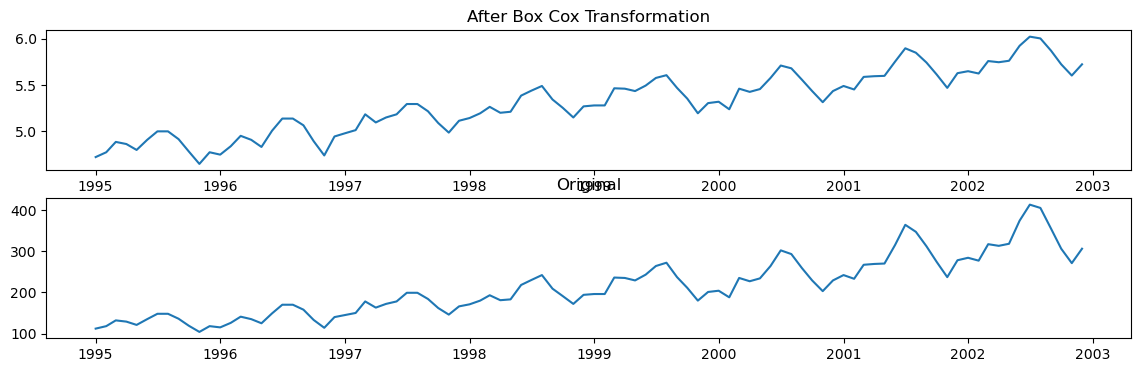

In [51]:
data_boxcox = pd.DataFrame()
data_boxcox['Passengers'] = pd.Series(boxcox(df1['Passengers'], lmbda=0), df1.index)
display(data_boxcox.head())
fig, axis = plt.subplots(2,figsize=(14,4),)
axis[0].plot(data_boxcox)
axis[0].set_title('After Box Cox Transformation')
axis[1].plot(df1, label='original')
axis[1].set_title('Original')
plt.show()

##### Differencing box cox transformation

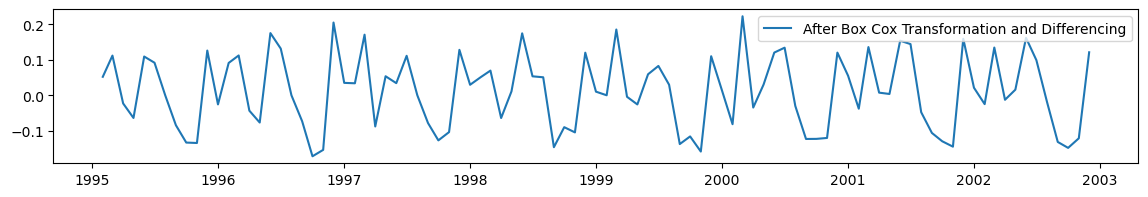

In [52]:
data_boxcox_diff = data_boxcox - data_boxcox.shift()
data_boxcox_diff.dropna(inplace=True)
plt.figure(figsize=(14,2))
plt.plot(data_boxcox_diff, label='After Box Cox Transformation and Differencing')
plt.legend(loc='best')
plt.show()

In [53]:
test_stationarity(data_boxcox_diff)

Results of Dickey Fuller Test:
Test Statistic                 -2.670823
p-value                         0.079225
#Lags Used                     12.000000
Number of Observations Used    82.000000
dtype: float64


In [54]:
def evaluate_arima_model(X, arima_order):
# prepare training dataset
    X = X.astype('float32')
    train_size = int(len(X) * 0.70)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
# make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
# calculate out of sample error
    rmse = np.sqrt(mean_squared_error(test, predictions))
    return rmse

In [55]:
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float('inf'), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    #print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except Exception as e:
                    print(e)
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [56]:
from numpy import sqrt

In [58]:
p_values = range(0, 5)
d_values = range(0, 5)
q_values = range(0, 5)
evaluate_models(data_boxcox_diff.Passengers, p_values, d_values, q_values)

Best ARIMA(4, 1, 4) RMSE=0.074


The best ARIMA model is obtained when p=4, d=1, q=4. In such a model, the RMSE is 0.074

In [59]:
train_data_boxcox = data_boxcox[:size]
test_data_boxcox = data_boxcox[size:]
train_data_boxcox_diff = data_boxcox_diff[:size]
test_data_boxcox_diff = data_boxcox_diff[size:]

In [60]:
model = ARIMA(train_data_boxcox_diff, order=(4, 1, 4))
model_fit = model.fit()
y_hat_ar = data_boxcox_diff.copy()
y_hat_ar['arima_forecast'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_ar['arima_forecast'] = y_hat_ar['arima_forecast'].cumsum()
y_hat_ar['arima_forecast'] = y_hat_ar['arima_forecast'].add(data_boxcox.Passengers[0])
y_hat_ar['arima_forecast'] = np.exp(y_hat_ar['arima_forecast'])

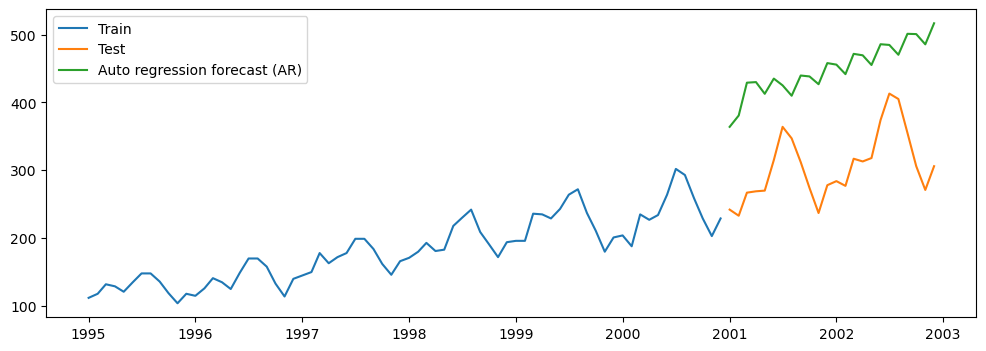

In [61]:
plt.figure(figsize=(12,4))
plt.plot(train_data['Passengers'], label='Train')
plt.plot(test_data, label='Test')
plt.plot(y_hat_ar['arima_forecast'][test_data.index.min():], label='Auto regression forecast (AR)')
plt.legend(loc='best')
plt.show()

In [62]:
rmse_ARIMA = np.sqrt(mean_squared_error(test_data, y_hat_ar['arima_forecast'][test_data.index.min():])).round(2)
rmse_ARIMA

149.74

In [63]:
model_residual = model_fit.resid
model_residual.mean()

-0.0056686480361455675

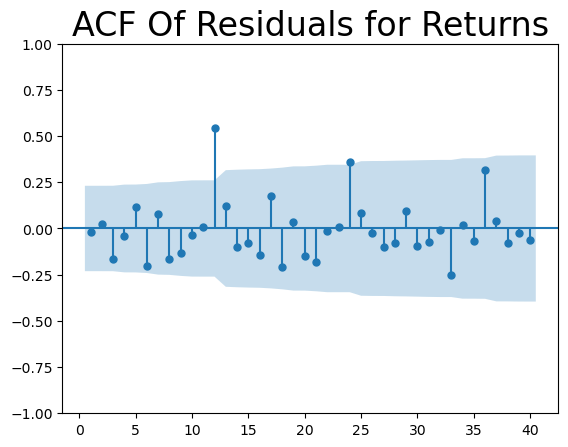

In [64]:
plot_acf(model_residual, zero = False, lags = 40)
plt.title("ACF Of Residuals for Returns",size=24)
plt.show()

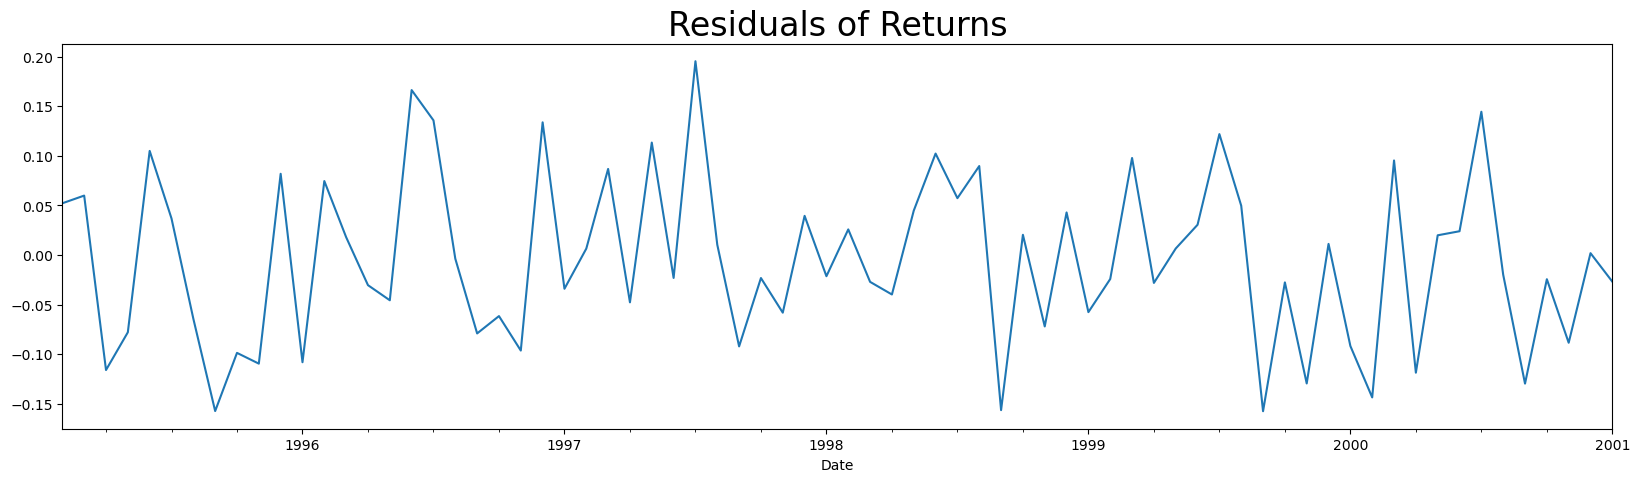

In [65]:
model_residual.plot(figsize=(20,5))
plt.title("Residuals of Returns", size=24)
plt.show()

#### SARIMA model

In [66]:
model = SARIMAX(train_data_boxcox, order=(1,1,1), seasonal_order=(1,1,1,12))
model_fit= model.fit()
y_hat_sarima = data_boxcox_diff.copy()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.32501D+00    |proj g|=  4.45863D+00

At iterate    5    f= -1.34824D+00    |proj g|=  1.68796D-01

At iterate   10    f= -1.36598D+00    |proj g|=  1.63301D+00

At iterate   15    f= -1.36777D+00    |proj g|=  1.03701D-01

At iterate   20    f= -1.37077D+00    |proj g|=  6.01698D-02

At iterate   25    f= -1.37769D+00    |proj g|=  1.31141D-01

At iterate   30    f= -1.37798D+00    |proj g|=  3.61942D-02

At iterate   35    f= -1.37852D+00    |proj g|=  7.89484D-02

At iterate   40    f= -1.38062D+00    |proj g|=  3.16829D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


In [67]:
y_hat_sarima['sarima_forecast_boxcox'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_sarima['sarima_forecast'] = np.exp(y_hat_sarima['sarima_forecast_boxcox'])
y_hat_sarima['sarima_forecast'] = np.exp(y_hat_sarima['sarima_forecast_boxcox'])

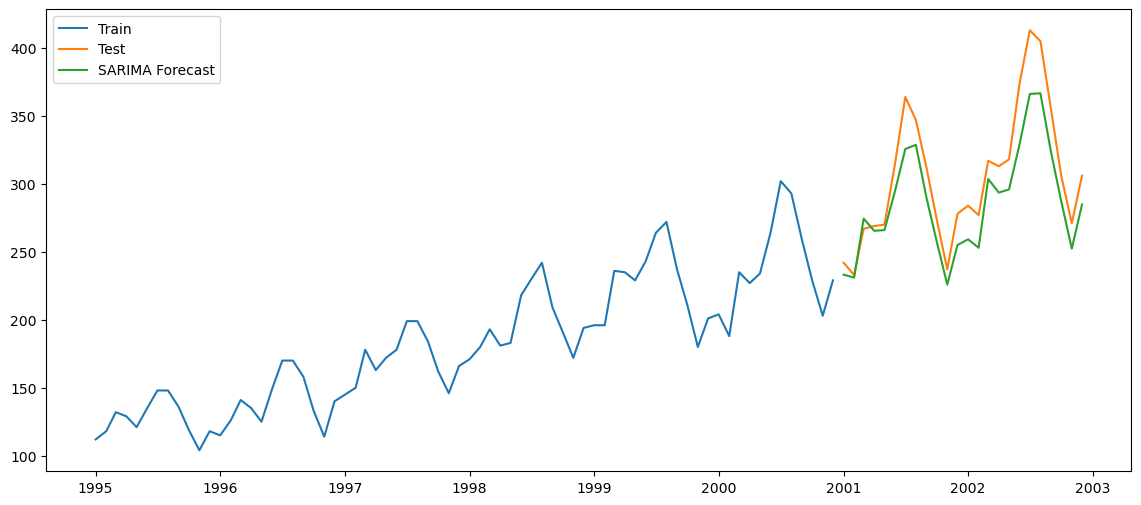

In [68]:
plt.figure(figsize=(14,6))
plt.plot(train_data['Passengers'], label='Train')
plt.plot(test_data, label='Test')
plt.plot(y_hat_sarima['sarima_forecast'][test_data.index.min():], label='SARIMA Forecast')
plt.legend(loc='best')
plt.show()

In [69]:
rmse_SARIMA = np.sqrt(mean_squared_error(test_data, y_hat_sarima['sarima_forecast'][test_data.index.min():])).round(2)
rmse_SARIMA

24.01

In [70]:
model_residual = model_fit.resid
model_residual.mean()

0.03587156458495382

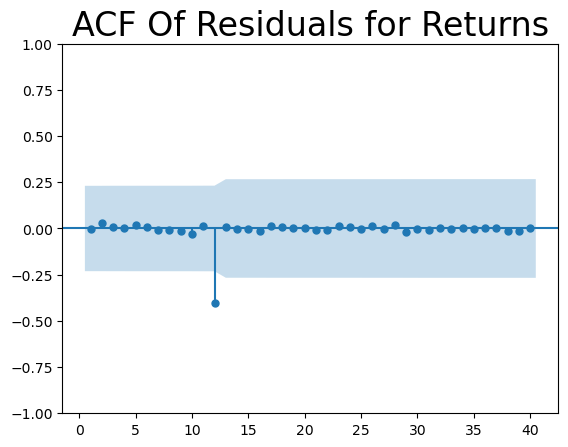

In [71]:
plot_acf(model_residual, zero = False, lags = 40)
plt.title("ACF Of Residuals for Returns",size=24)
plt.show()

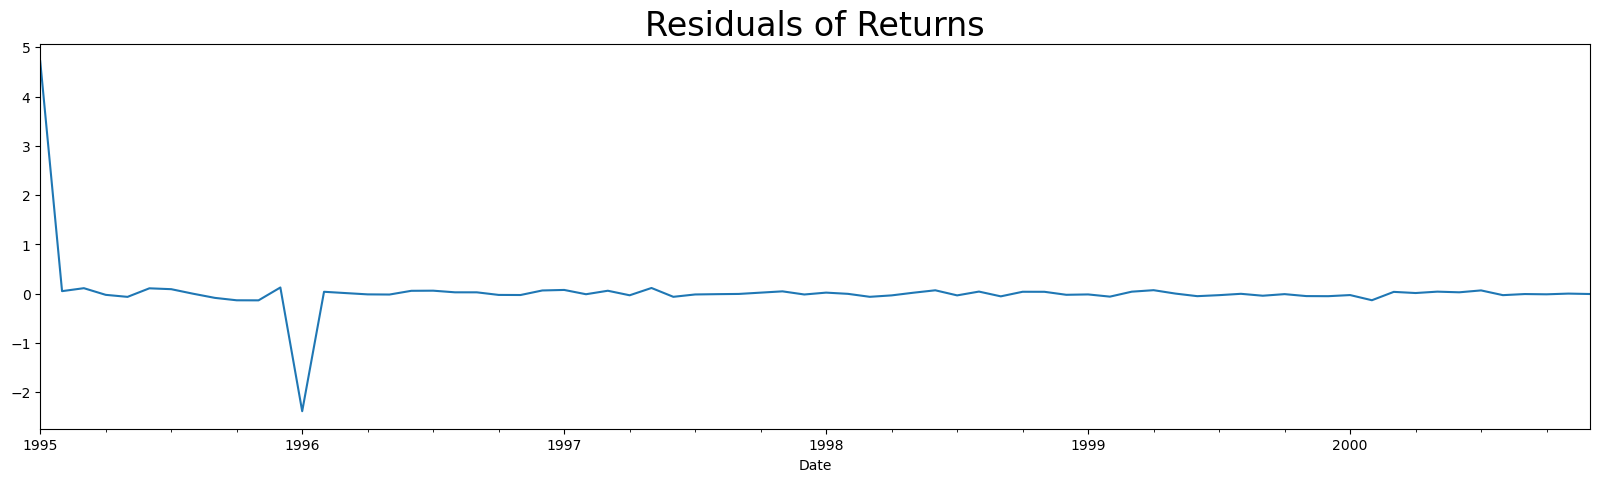

In [72]:
model_residual.plot(figsize=(20,5))
plt.title("Residuals of Returns", size=24)
plt.show()

In [73]:
Evaluation = {"Models":pd.Series(["Simple_Exponential","Double_Exponential","Triple_Exp_additive","Triple_Exp_mul_ad","Triple_Exp_ad_mul"\
                                  ,"Triple_Exp_multiplicative","ARIMA","SARIMA"]),\
        "RMSE_Values":pd.Series([test_rmse_ses,test_rmse_dexp,test_rmse_ad_texp,test_rmse_mul_ad_texp,test_rmse_ad_mul_texp,test_rmse_mul_texp,rmse_ARIMA,rmse_SARIMA])}
table_evaluation=pd.DataFrame(Evaluation)
table_evaluation.sort_values(['RMSE_Values'], inplace=True, ignore_index=True)
table_evaluation

,Models,RMSE_Values
0,Triple_Exp_multiplicative,23.058842
1,SARIMA,24.010000
2,Triple_Exp_mul_ad,34.989554
3,Triple_Exp_additive,47.570269
4,Triple_Exp_ad_mul,48.342084
5,Double_Exponential,71.552552
6,Simple_Exponential,91.113254
7,ARIMA,149.740000


The different models used along with the RMSE obtained with corresponding model is shown here. The least error is obtained for Holts winter exponential smoothing with multiplicative seasonality and multiplicative trend (Triple Exponential).

In [74]:
cocacola = df1.copy()
cocacola.reset_index(inplace=True)
cocacola['t'] = np.arange(1,len(cocacola)+1)
cocacola['t_squared'] = np.square(cocacola.t)
cocacola["month"] = cocacola.Date.dt.strftime("%b") # month extraction
cocacola["year"] = cocacola.Date.dt.strftime("%Y") # year extraction
months = pd.get_dummies(cocacola['month'])
months = months[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']]
cocacola = pd.concat([cocacola,months],axis=1)
cocacola['log_passengers'] = np.log(cocacola['Passengers'])
cocacola

,Date,Passengers,t,t_squared,month,year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,log_passengers
0,1995-01-01,112,1,1,Jan,1995,1,0,0,0,0,0,0,0,0,0,0,0,4.718499
1,1995-02-01,118,2,4,Feb,1995,0,1,0,0,0,0,0,0,0,0,0,0,4.770685
2,1995-03-01,132,3,9,Mar,1995,0,0,1,0,0,0,0,0,0,0,0,0,4.882802
3,1995-04-01,129,4,16,Apr,1995,0,0,0,1,0,0,0,0,0,0,0,0,4.859812
4,1995-05-01,121,5,25,May,1995,0,0,0,0,1,0,0,0,0,0,0,0,4.795791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,2002-08-01,405,92,8464,Aug,2002,0,0,0,0,0,0,0,1,0,0,0,0,6.003887
92,2002-09-01,355,93,8649,Sep,2002,0,0,0,0,0,0,0,0,1,0,0,0,5.872118
93,2002-10-01,306,94,8836,Oct,2002,0,0,0,0,0,0,0,0,0,1,0,0,5.723585
94,2002-11-01,271,95,9025,Nov,2002,0,0,0,0,0,0,0,0,0,0,1,0,5.602119


In [75]:
train_data = cocacola.iloc[:size]
test_data = cocacola.iloc[size:]

In [76]:
import statsmodels.formula.api as smf 

linear_model = smf.ols('Passengers~t',data=train_data).fit()
pred_linear =  pd.Series(linear_model.predict(pd.DataFrame(test_data['t'])))
rmse_linear = np.sqrt(np.mean((np.array(test_data['Passengers'])-np.array(pred_linear))**2))
rmse_linear

51.667792995646266

In [77]:
linear_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Passengers   R-squared:                       0.757
Model:                            OLS   Adj. R-squared:                  0.753
Method:                 Least Squares   F-statistic:                     217.9
Date:                Wed, 23 Aug 2023   Prob (F-statistic):           3.50e-23
Time:                        12:26:41   Log-Likelihood:                -329.04
No. Observations:                  72   AIC:                             662.1
Df Residuals:                      70   BIC:                             666.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    110.5243      5.643     19.586      0.000      99.270     121.779
t              1.9830      0.134     14.760      0.000       1.715       2.251
==============================================================================
Omnibus:                        0.634   Durbin-Watson:                   0.659
Prob(Omnibus):                  0.728   Jarque-Bera (JB):                0.667
Skew:                           0.213   Prob(JB):                        0.717
Kurtosis:                       2.799   Cond. No.                         84.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [78]:
#Exponential

Exp = smf.ols('log_passengers~t',data=train_data).fit()
pred_Exp = pd.Series(Exp.predict(pd.DataFrame(test_data['t'])))
rmse_Exp = np.sqrt(np.mean((np.array(test_data['Passengers'])-np.array(np.exp(pred_Exp)))**2))
rmse_Exp

42.55232894600461

In [79]:
Exp.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         log_passengers   R-squared:                       0.779
Model:                            OLS   Adj. R-squared:                  0.776
Method:                 Least Squares   F-statistic:                     246.3
Date:                Wed, 23 Aug 2023   Prob (F-statistic):           1.28e-24
Time:                        12:26:41   Log-Likelihood:                 48.708
No. Observations:                  72   AIC:                            -93.42
Df Residuals:                      70   BIC:                            -88.86
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.7699      0.030    160.519      0.000       4.711       4.829
t              0.0111      0.001     15.693      0.000       0.010       0.013
==============================================================================
Omnibus:                        2.000   Durbin-Watson:                   0.687
Prob(Omnibus):                  0.368   Jarque-Bera (JB):                1.573
Skew:                          -0.186   Prob(JB):                        0.456
Kurtosis:                       2.378   Cond. No.                         84.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [80]:
#Quadratic 

Quad = smf.ols('Passengers~t+t_squared',data=train_data).fit()
pred_Quad = pd.Series(Quad.predict(test_data[["t","t_squared"]]))
rmse_Quad = np.sqrt(np.mean((np.array(test_data['Passengers'])-np.array(pred_Quad))**2))
rmse_Quad

51.990736401553846

In [81]:
Quad.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Passengers   R-squared:                       0.757
Model:                            OLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     107.4
Date:                Wed, 23 Aug 2023   Prob (F-statistic):           6.52e-22
Time:                        12:26:41   Log-Likelihood:                -329.04
No. Observations:                  72   AIC:                             664.1
Df Residuals:                      69   BIC:                             670.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    110.2764      8.677     12.710      0.000      92.967     127.586
t              2.0031      0.549      3.652      0.001       0.909       3.097
t_squared     -0.0003      0.007     -0.038      0.970      -0.015       0.014
==============================================================================
Omnibus:                        0.649   Durbin-Watson:                   0.659
Prob(Omnibus):                  0.723   Jarque-Bera (JB):                0.679
Skew:                           0.216   Prob(JB):                        0.712
Kurtosis:                       2.799   Cond. No.                     7.29e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.29e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [82]:
#Additive seasonality 

add_sea = smf.ols('Passengers~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data=train_data).fit()
pred_add_sea = pd.Series(add_sea.predict(test_data[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']]))
rmse_add_sea = np.sqrt(np.mean((np.array(test_data['Passengers'])-np.array(pred_add_sea))**2))
rmse_add_sea

127.26451565320339

In [83]:
add_sea.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Passengers   R-squared:                       0.202
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     1.379
Date:                Wed, 23 Aug 2023   Prob (F-statistic):              0.206
Time:                        12:26:41   Log-Likelihood:                -371.83
No. Observations:                  72   AIC:                             767.7
Df Residuals:                      60   BIC:                             795.0
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    168.8333      5.044     33.475      0.000     158.745     178.922
Jan          -11.6667     18.126     -0.644      0.522     -47.925      24.591
Feb           -9.1667     18.126     -0.506      0.615     -45.425      27.091
Mar           17.0000     18.126      0.938      0.352     -19.258      53.258
Apr            9.5000     18.126      0.524      0.602     -26.758      45.758
May            8.5000     18.126      0.469      0.641     -27.758      44.758
Jun           29.0000     18.126      1.600      0.115      -7.258      65.258
Jul           50.0000     18.126      2.758      0.008      13.742      86.258
Aug           51.8333     18.126      2.860      0.006      15.575      88.091
Sep           28.3333     18.126      1.563      0.123      -7.925      64.591
Oct            5.3333     18.126      0.294      0.770     -30.925      41.591
Nov          -15.6667     18.126     -0.864      0.391     -51.925      20.591
Dec            5.8333     18.126      0.322      0.749     -30.425      42.091
==============================================================================
Omnibus:                       29.671   Durbin-Watson:                   0.050
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                4.962
Skew:                           0.033   Prob(JB):                       0.0837
Kurtosis:                       1.716   Cond. No.                     1.94e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.08e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [84]:
#Additive Seasonality Quadratic 

add_sea_Quad = smf.ols('Passengers~t+t_squared+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data=train_data).fit()
pred_add_sea_quad = pd.Series(add_sea_Quad.predict(test_data[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec','t','t_squared']]))
rmse_add_sea_quad = np.sqrt(np.mean((np.array(test_data['Passengers'])-np.array(pred_add_sea_quad))**2))
rmse_add_sea_quad

35.24160848592733

In [85]:
add_sea_Quad.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Passengers   R-squared:                       0.958
Model:                            OLS   Adj. R-squared:                  0.948
Method:                 Least Squares   F-statistic:                     101.2
Date:                Wed, 23 Aug 2023   Prob (F-statistic):           7.45e-35
Time:                        12:26:41   Log-Likelihood:                -266.00
No. Observations:                  72   AIC:                             560.0
Df Residuals:                      58   BIC:                             591.9
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    101.8335      3.657     27.847      0.000      94.513     109.154
t              1.9472      0.250      7.802      0.000       1.448       2.447
t_squared      0.0009      0.003      0.259      0.797      -0.006       0.007
Jan           -6.2122      4.246     -1.463      0.149     -14.712       2.287
Feb           -5.7134      4.246     -1.346      0.184     -14.212       2.785
Mar           18.4504      4.246      4.345      0.000       9.951      26.949
Apr            8.9458      4.247      2.106      0.039       0.445      17.447
May            5.9395      4.248      1.398      0.167      -2.564      14.444
Jun           24.4315      4.250      5.748      0.000      15.923      32.940
Jul           43.4218      4.253     10.210      0.000      34.909      51.935
Aug           43.2437      4.256     10.161      0.000      34.724      51.763
Sep           17.7306      4.260      4.162      0.000       9.204      26.257
Oct           -7.2843      4.264     -1.708      0.093     -15.819       1.251
Nov          -30.3009      4.269     -7.098      0.000     -38.846     -21.756
Dec          -10.8192      4.274     -2.531      0.014     -19.375      -2.263
==============================================================================
Omnibus:                        1.717   Durbin-Watson:                   0.668
Prob(Omnibus):                  0.424   Jarque-Bera (JB):                1.039
Skew:                          -0.185   Prob(JB):                        0.595
Kurtosis:                       3.458   Cond. No.                     3.73e+19
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.88e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [86]:
##Multiplicative Seasonality

Mul_sea = smf.ols('log_passengers~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data = train_data).fit()
pred_Mult_sea = pd.Series(Mul_sea.predict(test_data))
rmse_Mult_sea = np.sqrt(np.mean((np.array(test_data['Passengers'])-np.array(np.exp(pred_Mult_sea)))**2))
rmse_Mult_sea

132.18762800263445

In [87]:
Mul_sea.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         log_passengers   R-squared:                       0.189
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     1.268
Date:                Wed, 23 Aug 2023   Prob (F-statistic):              0.265
Time:                        12:26:42   Log-Likelihood:                 1.9383
No. Observations:                  72   AIC:                             20.12
Df Residuals:                      60   BIC:                             47.44
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.7771      0.028    170.187      0.000       4.721       4.833
Jan            0.2526      0.101      2.504      0.015       0.051       0.454
Feb            0.2771      0.101      2.747      0.008       0.075       0.479
Mar            0.4229      0.101      4.192      0.000       0.221       0.625
Apr            0.3799      0.101      3.766      0.000       0.178       0.582
May            0.3680      0.101      3.648      0.001       0.166       0.570
Jun            0.4804      0.101      4.762      0.000       0.279       0.682
Jul            0.5814      0.101      5.763      0.000       0.380       0.783
Aug            0.5898      0.101      5.847      0.000       0.388       0.792
Sep            0.4825      0.101      4.783      0.000       0.281       0.684
Oct            0.3554      0.101      3.523      0.001       0.154       0.557
Nov            0.2259      0.101      2.239      0.029       0.024       0.428
Dec            0.3611      0.101      3.580      0.001       0.159       0.563
==============================================================================
Omnibus:                       56.848   Durbin-Watson:                   0.043
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                6.403
Skew:                          -0.180   Prob(JB):                       0.0407
Kurtosis:                       1.584   Cond. No.                     1.94e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.08e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [88]:
#Multiplicative Additive Seasonality 

Mul_Add_sea = smf.ols('log_passengers~t+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data = train_data).fit()
pred_Mult_add_sea = pd.Series(Mul_Add_sea.predict(test_data))
rmse_Mult_add_sea = np.sqrt(np.mean((np.array(test_data['Passengers'])-np.array(np.exp(pred_Mult_add_sea)))**2))
rmse_Mult_add_sea 

11.714670246780837

In [89]:
Mul_Add_sea.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         log_passengers   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.962
Method:                 Least Squares   F-statistic:                     149.0
Date:                Wed, 23 Aug 2023   Prob (F-statistic):           1.95e-39
Time:                        12:26:42   Log-Likelihood:                 118.39
No. Observations:                  72   AIC:                            -210.8
Df Residuals:                      59   BIC:                            -181.2
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.3975      0.011    383.337      0.000       4.375       4.420
t              0.0113      0.000     37.943      0.000       0.011       0.012
Jan            0.2829      0.020     14.007      0.000       0.243       0.323
Feb            0.2962      0.020     14.669      0.000       0.256       0.337
Mar            0.4306      0.020     21.334      0.000       0.390       0.471
Apr            0.3765      0.020     18.650      0.000       0.336       0.417
May            0.3532      0.020     17.497      0.000       0.313       0.394
Jun            0.4544      0.020     22.497      0.000       0.414       0.495
Jul            0.5441      0.020     26.926      0.000       0.504       0.585
Aug            0.5413      0.020     26.763      0.000       0.501       0.582
Sep            0.4227      0.020     20.879      0.000       0.382       0.463
Oct            0.2844      0.020     14.028      0.000       0.244       0.325
Nov            0.1436      0.020      7.073      0.000       0.103       0.184
Dec            0.2676      0.020     13.157      0.000       0.227       0.308
==============================================================================
Omnibus:                        4.430   Durbin-Watson:                   0.630
Prob(Omnibus):                  0.109   Jarque-Bera (JB):                3.600
Skew:                          -0.438   Prob(JB):                        0.165
Kurtosis:                       3.658   Cond. No.                     8.34e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.83e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [90]:
data = {"Models":pd.Series(["rmse_linear","rmse_Exp","rmse_Quad","rmse_add_sea","rmse_add_sea_quad","rmse_Mult_sea","rmse_Mult_add_sea"]),"RMSE_Values":pd.Series([rmse_linear,rmse_Exp,rmse_Quad,rmse_add_sea,rmse_add_sea_quad,rmse_Mult_sea,rmse_Mult_add_sea])}
table_rmse=pd.DataFrame(data)
table_rmse.sort_values(['RMSE_Values'], inplace=True, ignore_index=True)
table_rmse

,Models,RMSE_Values
0,rmse_Mult_add_sea,11.714670
1,rmse_add_sea_quad,35.241608
2,rmse_Exp,42.552329
3,rmse_linear,51.667793
4,rmse_Quad,51.990736
5,rmse_add_sea,127.264516
6,rmse_Mult_sea,132.187628


The OLS method is applied on different models and the RMSE values are tabulated as shown. Multiplicative additive seasonality is giving the best RMSE value and hence is the best method to be used here. Multiplicative additive seasonality is obtained as: log y ~ t + seasonality